# Training Fundamentals

Before any architecture work, establish proper training and validation.

## Goals
1. Proper training loop with curriculum
2. Correct validation metrics
3. Baseline comparison (transformer)
4. Tests that can't be gamed

In [ ]:
# Cell 1: Imports
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, IterableDataset
import numpy as np
from dataclasses import dataclass
from typing import Optional, Tuple, Dict
import math
import sys

# Add current directory for local imports
sys.path.insert(0, '.')
from config import HybridConfig
from model import TransparentHybrid

# Reproducibility
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device: {device}")
print(f"Seed: {SEED}")
print(f"PyTorch: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Device: cuda
PyTorch: 2.11.0.dev20260128+cu128
CUDA available: True
GPU: NVIDIA GeForce RTX 4050 Laptop GPU
VRAM: 6.4 GB


## Reference Requirements Summary

Per the 5 reference docs:

**Training (ssm_training_text.md)**
- LR: 1.5e-4 to 4.5e-4 peak, cosine/WSD schedule
- Warmup: 2000-4000 steps
- SSM params in FP32 if instability
- Curriculum: 256→4096 tokens

**Validation (diagnosing-hybrid-ssm-attention.md)**
- Expected PPL: 33-90 for 10-100M params
- Distinct-2 > 0.5
- Repetition < 10%
- Generated PPL: 12-20
- Memory Reliance Score > 70%

**Scale (proof_of_concept.md)**
- d_model ≥ 512 (below = dead zone)
- ~20 tokens per parameter
- 350M-1.3B for architecture validation

In [ ]:
# =============================================================================
# TRAINING CONFIG - SSM HYBRID (GS = GDN + SWA stacked)
# =============================================================================
# 
# From our test: GS works better than PP (parallel)
#   Stacked: retrieval_norm=0.9, loss=3.656
#   Parallel: retrieval_norm=0.4, loss=4.161
#
# Memory-safe for RTX 4050 6GB:
#   d_model=256, n_heads=4, batch_size=2, seq_len up to 512
# =============================================================================

@dataclass
class TrainingConfig:
    """
    SSM Hybrid Training Config.
    Memory-safe for 6GB VRAM.
    """
    # === MODEL ===
    layer_pattern: str = 'GS'  # GDN layer 0, SWA layer 1
    d_model: int = 256
    n_heads: int = 4
    head_dim: int = 32
    value_dim: int = 32
    vocab_size: int = 50257
    
    # === OPTIMIZER (per ssm_training_text.md) ===
    lr_peak: float = 3e-4
    lr_min: float = 1e-5
    weight_decay: float = 0.1
    beta1: float = 0.9
    beta2: float = 0.95
    grad_clip: float = 1.0
    
    # === SCHEDULE ===
    warmup_steps: int = 500
    total_steps: int = 3000
    
    # === CURRICULUM ===
    # Start short, build to longer sequences
    curriculum_schedule: list = None  # Set below
    
    # === MEMORY-SAFE FOR 6GB ===
    batch_size: int = 2
    accum_steps: int = 8  # Effective batch size = 16
    use_amp: bool = True
    
    # === VALIDATION ===
    val_every: int = 200
    
    def __post_init__(self):
        # Curriculum: (step_threshold, seq_len)
        self.curriculum_schedule = [
            (0, 128),      # Steps 0-749: seq=128
            (750, 256),    # Steps 750-1499: seq=256
            (1500, 384),   # Steps 1500-2249: seq=384
            (2250, 512),   # Steps 2250+: seq=512
        ]
    
    def get_seq_len(self, step: int) -> int:
        """Get sequence length at current step."""
        seq_len = self.curriculum_schedule[0][1]
        for threshold, length in self.curriculum_schedule:
            if step >= threshold:
                seq_len = length
        return seq_len

cfg = TrainingConfig()

print("="*60)
print("SSM HYBRID TRAINING CONFIG")
print("="*60)
print(f"\nArchitecture: {cfg.layer_pattern}")
print(f"  d_model: {cfg.d_model}, n_heads: {cfg.n_heads}")
print(f"  head_dim: {cfg.head_dim}, value_dim: {cfg.value_dim}")

print(f"\nOptimizer:")
print(f"  LR: {cfg.lr_peak} → {cfg.lr_min}")
print(f"  AdamW: β1={cfg.beta1}, β2={cfg.beta2}")
print(f"  Warmup: {cfg.warmup_steps} steps")

print(f"\nCurriculum:")
for threshold, length in cfg.curriculum_schedule:
    print(f"  Step {threshold:>4}+: seq_len={length}")

print(f"\nMemory-safe: batch={cfg.batch_size}, AMP={cfg.use_amp}")
print(f"Gradient accumulation: {cfg.accum_steps} steps (effective batch = {cfg.batch_size * cfg.accum_steps})")

SSM HYBRID TRAINING CONFIG

Architecture: GS
  d_model: 256, n_heads: 4
  head_dim: 32, value_dim: 32

Optimizer:
  LR: 0.0003 → 1e-05
  AdamW: β1=0.9, β2=0.95
  Warmup: 500 steps

Curriculum:
  Step    0+: seq_len=128
  Step  750+: seq_len=256
  Step 1500+: seq_len=384
  Step 2250+: seq_len=512

Memory-safe: batch=2, AMP=True


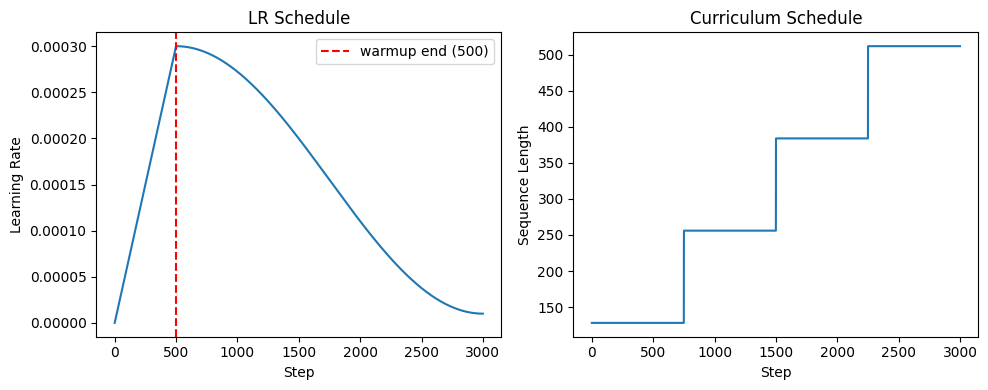

In [4]:
# Cell 5: LR Schedule with Warmup + Cosine Decay

def get_lr(step: int, cfg: TrainingConfig) -> float:
    """Warmup + cosine decay schedule."""
    if step < cfg.warmup_steps:
        return cfg.lr_peak * (step / cfg.warmup_steps)
    else:
        progress = (step - cfg.warmup_steps) / (cfg.total_steps - cfg.warmup_steps)
        return cfg.lr_min + 0.5 * (cfg.lr_peak - cfg.lr_min) * (1 + math.cos(math.pi * progress))

# Visualize schedule
import matplotlib.pyplot as plt

steps = list(range(cfg.total_steps))
lrs = [get_lr(s, cfg) for s in steps]
seq_lens = [cfg.get_seq_len(s) for s in steps]

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(steps, lrs)
plt.axvline(cfg.warmup_steps, color='r', linestyle='--', label=f'warmup end ({cfg.warmup_steps})')
plt.xlabel('Step')
plt.ylabel('Learning Rate')
plt.title('LR Schedule')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(steps, seq_lens)
plt.xlabel('Step')
plt.ylabel('Sequence Length')
plt.title('Curriculum Schedule')

plt.tight_layout()
plt.show()

In [5]:
# Cell 4: Tokenizer + Data Loading
from transformers import GPT2Tokenizer
from datasets import load_dataset

tokenizer = GPT2Tokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

print(f"Vocab size: {tokenizer.vocab_size}")

# Load TinyStories for now (small, fits in memory)
ds = load_dataset('roneneldan/TinyStories', split='train', streaming=True)
print("Dataset loaded (streaming)")

Vocab size: 50257
Dataset loaded (streaming)


In [6]:
# Cell 5: Validation Metrics
# Per diagnosing-hybrid-ssm-attention.md

def compute_distinct_n(texts: list, n: int = 2) -> float:
    """Distinct-n: ratio of unique n-grams to total n-grams."""
    all_ngrams = []
    for text in texts:
        tokens = text.split()
        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        all_ngrams.extend(ngrams)
    if len(all_ngrams) == 0:
        return 0.0
    return len(set(all_ngrams)) / len(all_ngrams)

def compute_repetition_rate(texts: list, n: int = 4) -> float:
    """Repetition rate: fraction of n-grams that appear more than once."""
    from collections import Counter
    all_ngrams = []
    for text in texts:
        tokens = text.split()
        ngrams = [tuple(tokens[i:i+n]) for i in range(len(tokens)-n+1)]
        all_ngrams.extend(ngrams)
    if len(all_ngrams) == 0:
        return 0.0
    counts = Counter(all_ngrams)
    repeated = sum(1 for c in counts.values() if c > 1)
    return repeated / len(counts) if len(counts) > 0 else 0.0

def compute_ppl(model, tokens, device):
    """Compute perplexity on tokens."""
    model.eval()
    with torch.no_grad():
        logits = model(tokens.to(device))
        if isinstance(logits, tuple):
            logits = logits[0]
        loss = F.cross_entropy(
            logits[:, :-1].reshape(-1, logits.size(-1)),
            tokens[:, 1:].reshape(-1).to(device)
        )
    return math.exp(loss.item())

# Test the metrics
test_texts = [
    "The quick brown fox jumps over the lazy dog",
    "Once upon a time there was a little girl",
    "The cat sat on the mat and looked around"
]
print(f"Distinct-2: {compute_distinct_n(test_texts, 2):.3f} (target: >0.5)")
print(f"Repetition-4: {compute_repetition_rate(test_texts, 4):.3f} (target: <0.1)")

# Bad example
bad_texts = ["time time time time time time time time"]
print(f"\nBad example Distinct-2: {compute_distinct_n(bad_texts, 2):.3f}")
print(f"Bad example Repetition-4: {compute_repetition_rate(bad_texts, 4):.3f}")

Distinct-2: 1.000 (target: >0.5)
Repetition-4: 0.000 (target: <0.1)

Bad example Distinct-2: 0.143
Bad example Repetition-4: 1.000


In [ ]:
# =============================================================================
# CREATE GDN + SWA HYBRID MODEL (GS pattern)
# =============================================================================
# 
# Using our REAL TransparentHybrid from model.py
# GS = GDN at layer 0 (state write), SWA at layer 1 (state read + local attn)

model_cfg = HybridConfig(
    layer_pattern=cfg.layer_pattern,
    d_model=cfg.d_model,
    n_heads=cfg.n_heads,
    head_dim=cfg.head_dim,
    value_dim=cfg.value_dim,
    vocab_size=cfg.vocab_size,
    window_size=128,  # Local attention window
    local_drop_prob=0.5,  # Force some retrieval learning
    local_scale=0.3,
)

model = TransparentHybrid(model_cfg).to(device)

n_params = model.count_params()
print(f"Model: {n_params/1e6:.2f}M parameters")
print(f"Pattern: {cfg.layer_pattern}")
print(f"Layers: {len(model.layers)}")

# Check initial forward pass - FlashAttention requires fp16/bf16
model.eval()
with torch.no_grad(), torch.amp.autocast('cuda'):
    test_ids = torch.randint(0, cfg.vocab_size, (2, 65), device=device)  # +1 for shift
    logits, loss, diag, state = model(test_ids[:, :-1], targets=test_ids[:, 1:])
    print(f"Initial loss: {loss.item():.2f} (expected ~{math.log(cfg.vocab_size):.2f})")
    print(f"State shape: {state.shape if state is not None else 'None'}")
    
# Show layer diagnostics
for d in diag:
    layer_type = d.get('layer', '?')
    layer_idx = d.get('layer_idx', '?')
    print(f"  Layer {layer_idx} ({layer_type}):", end=' ')
    if 'retrieval_norm' in d:
        print(f"retrieval={d['retrieval_norm']:.1f}, local={d['local_norm']:.1f}", end='')
    if 'state_norm' in d:
        print(f", state={d['state_norm']:.1f}", end='')
    print()

Model: 14.39M parameters
Pattern: GS
Layers: 2
Initial loss: 5.79 (expected ~10.82)
State shape: torch.Size([2, 4, 32, 32])
  Layer 0 (G): , state=0.3
  Layer 1 (S): retrieval=1.1, local=5.1


In [ ]:
# Cell: Data Loading (TinyStories - small, fits memory)
from transformers import AutoTokenizer
from datasets import load_dataset

tokenizer = AutoTokenizer.from_pretrained('gpt2')
tokenizer.pad_token = tokenizer.eos_token

def get_data_loader(split='train', max_samples=5000):
    """Load TinyStories with memory-efficient chunking."""
    ds = load_dataset('roneneldan/TinyStories', split=f'{split}[:10000]')
    
    # Tokenize all at once (TinyStories is small)
    all_tokens = []
    for example in ds:
        text = example['text']
        if text.strip():
            tokens = tokenizer.encode(text, add_special_tokens=False)
            all_tokens.extend(tokens)
        if len(all_tokens) >= max_samples * 512:
            break
    
    return torch.tensor(all_tokens, dtype=torch.long)

print("Loading TinyStories...")
all_tokens = get_data_loader('train', max_samples=5000)

# 90/10 train/val split
split_idx = int(len(all_tokens) * 0.9)
train_tokens = all_tokens[:split_idx]
val_tokens = all_tokens[split_idx:]

print(f"Train tokens: {len(train_tokens):,}")
print(f"Val tokens: {len(val_tokens):,}")
print(f"Sample: {tokenizer.decode(train_tokens[:50].tolist())[:100]}...")


Loading TinyStories...


Token indices sequence length is longer than the specified maximum sequence length for this model (1106 > 1024). Running this sequence through the model will result in indexing errors


Train tokens: 2,152,078
Sample: One day, a little girl named Lily found a needle in her room. She knew it was difficult to play with...


In [ ]:
# Training utilities

def get_lr(step: int, cfg: TrainingConfig) -> float:
    """Warmup + cosine decay."""
    if step < cfg.warmup_steps:
        return cfg.lr_peak * (step / cfg.warmup_steps)
    progress = (step - cfg.warmup_steps) / (cfg.total_steps - cfg.warmup_steps)
    return cfg.lr_min + 0.5 * (cfg.lr_peak - cfg.lr_min) * (1 + math.cos(math.pi * progress))

def get_batch(tokens: torch.Tensor, seq_len: int, batch_size: int):
    """Random batch from token stream."""
    max_start = len(tokens) - seq_len - 1
    starts = torch.randint(0, max_start, (batch_size,))
    batch = torch.stack([tokens[s:s+seq_len+1] for s in starts])
    return batch[:, :-1], batch[:, 1:]  # inputs, targets

def compute_memory_reliance(diag: list) -> float:
    """
    Memory Reliance Score (MRS) per diagnosing-hybrid-ssm-attention.md.
    Target: > 70% means model is using SSM memory effectively.
    
    MRS = retrieval_norm / (retrieval_norm + local_norm)
    """
    retr = sum(d.get('retrieval_norm', 0) for d in diag)
    local = sum(d.get('local_norm', 0) for d in diag)
    return retr / (retr + local + 1e-8)

@torch.no_grad()
def validate(model, val_tokens, seq_len: int, batch_size: int, n_batches: int = 10):
    """Run validation and return loss, ppl, memory reliance score."""
    model.eval()
    total_loss = 0
    total_mrs = 0
    
    for _ in range(n_batches):
        inputs, targets = get_batch(val_tokens, seq_len, batch_size)
        inputs, targets = inputs.to(device), targets.to(device)
        
        with torch.amp.autocast('cuda'):
            logits, loss, diag, state = model(inputs, targets=targets)
        
        total_loss += loss.item()
        total_mrs += compute_memory_reliance(diag)
    
    avg_loss = total_loss / n_batches
    avg_mrs = total_mrs / n_batches
    return avg_loss, math.exp(avg_loss), avg_mrs

@torch.no_grad()
def evaluate_position_bias(model, val_tokens, seq_len: int = 256, n_samples: int = 50):
    """
    Test if accuracy varies by position (red flag for shortcut learning).
    Per references: >15% accuracy variation across positions indicates position bias.
    Genuine memory should have similar accuracy across all positions.
    """
    import random
    model.eval()
    
    # Divide sequence into 4 bins
    bin_size = seq_len // 4
    bin_correct = [0, 0, 0, 0]
    bin_total = [0, 0, 0, 0]
    
    with torch.amp.autocast('cuda'):
        for _ in range(n_samples):
            start = random.randint(0, len(val_tokens) - seq_len - 1)
            input_seq = val_tokens[start:start + seq_len].unsqueeze(0).to(device)
            target_seq = val_tokens[start + 1:start + seq_len + 1].to(device)
            
            logits, _, _, _ = model(input_seq)
            preds = logits[0].argmax(dim=-1)  # [seq_len]
            
            for pos in range(seq_len):
                bin_idx = min(pos // bin_size, 3)
                if preds[pos] == target_seq[pos]:
                    bin_correct[bin_idx] += 1
                bin_total[bin_idx] += 1
    
    bin_acc = [c / t if t > 0 else 0.0 for c, t in zip(bin_correct, bin_total)]
    acc_range = max(bin_acc) - min(bin_acc)
    
    return {
        'bin_accuracies': bin_acc,
        'accuracy_range': acc_range,
        'position_bias_flag': acc_range > 0.15,
    }

# Test batch
inputs, targets = get_batch(train_tokens, seq_len=128, batch_size=cfg.batch_size)
print(f"Batch shapes: inputs={inputs.shape}, targets={targets.shape}")
print(f"Sample input: {tokenizer.decode(inputs[0][:20].tolist())}")

Batch shapes: inputs=torch.Size([2, 128]), targets=torch.Size([2, 128])
Sample input:  both enjoyed their lunch together and were happy.Once upon a time, there was a little boy named


In [ ]:
# =============================================================================
# TRAIN GS MODEL WITH CURRICULUM
# =============================================================================

# Fresh model
torch.cuda.empty_cache()
model = TransparentHybrid(model_cfg).to(device)

optimizer = torch.optim.AdamW(
    model.parameters(),
    lr=cfg.lr_peak,
    betas=(cfg.beta1, cfg.beta2),
    weight_decay=cfg.weight_decay
)
scaler = torch.amp.GradScaler('cuda')

# History
history = {
    'loss': [], 'retrieval_norm': [], 'local_norm': [], 'state_norm': [],
    'step': [], 'seq_len': [], 'lr': []
}

print(f"Training {cfg.layer_pattern} for {cfg.total_steps} steps...")
print(f"Effective batch size: {cfg.batch_size * cfg.accum_steps}")
print("="*60)

optimizer.zero_grad()  # Move outside loop for accumulation

for step in range(cfg.total_steps):
    seq_len = cfg.get_seq_len(step)
    lr = get_lr(step, cfg)
    for pg in optimizer.param_groups:
        pg['lr'] = lr
    
    # Get batch
    inputs, targets = get_batch(train_tokens, seq_len, cfg.batch_size)
    inputs, targets = inputs.to(device), targets.to(device)
    
    # Forward
    model.train()
    
    with torch.amp.autocast('cuda', enabled=cfg.use_amp):
        logits, loss, diag, state = model(inputs, targets=targets)
        loss_scaled = loss / cfg.accum_steps  # Normalize for accumulation
    
    # Backward (accumulate gradients)
    scaler.scale(loss_scaled).backward()
    
    # Only step every accum_steps
    if (step + 1) % cfg.accum_steps == 0:
        scaler.unscale_(optimizer)
        torch.nn.utils.clip_grad_norm_(model.parameters(), cfg.grad_clip)
        scaler.step(optimizer)
        scaler.update()
        optimizer.zero_grad()
    
    # Log
    history['loss'].append(loss.item())
    history['step'].append(step)
    history['seq_len'].append(seq_len)
    history['lr'].append(lr)
    
    # Aggregate diagnostics
    retr = sum(d.get('retrieval_norm', 0) for d in diag)
    local = sum(d.get('local_norm', 0) for d in diag)
    state_n = sum(d.get('state_norm', 0) for d in diag)
    history['retrieval_norm'].append(retr)
    history['local_norm'].append(local)
    history['state_norm'].append(state_n)
    
    if step % 200 == 0 or step == cfg.total_steps - 1:
        ppl = math.exp(loss.item())
        retr_pct = 100 * retr / (retr + local + 1e-8)
        print(f"Step {step:4d}: loss={loss.item():.3f}, ppl={ppl:.1f}, seq={seq_len}, "
              f"retr={retr:.1f} ({retr_pct:.0f}%), local={local:.1f}, lr={lr:.2e}")
    
    # Periodic validation
    if step % cfg.val_every == 0 and step > 0:
        val_loss, val_ppl, val_mrs = validate(model, val_tokens, seq_len, cfg.batch_size)
        print(f"  [VAL] loss={val_loss:.3f}, ppl={val_ppl:.1f}, MRS={100*val_mrs:.1f}%")

# Final validation
val_loss, val_ppl, val_mrs = validate(model, val_tokens, cfg.get_seq_len(cfg.total_steps), cfg.batch_size, n_batches=20)

# Final stats
final_loss = sum(history['loss'][-50:]) / 50
final_ppl = math.exp(final_loss)
final_retr = sum(history['retrieval_norm'][-50:]) / 50
final_local = sum(history['local_norm'][-50:]) / 50

retr_ratio = final_retr / (final_retr + final_local + 1e-8)

# Train/val gap (per scaling_experiment.py - detect degenerate solutions)
train_val_gap = val_loss - final_loss
if abs(train_val_gap) < 0.01:
    print(f"⚠️  Train/val gap near zero ({train_val_gap:.4f}) - possible degenerate solution")

print("="*60)
print(f"FINAL RESULTS")
print("="*60)
print(f"  Train Loss: {final_loss:.3f}, PPL: {final_ppl:.1f}")
print(f"  Val Loss: {val_loss:.3f}, PPL: {val_ppl:.1f}")
print(f"  Train/Val Gap: {train_val_gap:.3f}")
print(f"  Retrieval: {final_retr:.1f} ({100*retr_ratio:.1f}%)")
print(f"  Memory Reliance Score: {100*val_mrs:.1f}% (target: >70%)")

# Position bias test
print(f"\nRunning position bias test...")
pos_test = evaluate_position_bias(model, val_tokens, seq_len=256, n_samples=50)
print(f"  Bin accuracies: {[f'{a:.3f}' for a in pos_test['bin_accuracies']]}")
print(f"  Accuracy range: {pos_test['accuracy_range']:.3f} (red flag if >0.15)")
if pos_test['position_bias_flag']:
    print(f"  ⚠️  Position bias detected!")

Training GS for 3000 steps...
Step    0: loss=10.885, ppl=53388.2, seq=128, retr=1.6 (4%), local=42.0, lr=0.00e+00
Step  200: loss=8.597, ppl=5413.8, seq=128, retr=3.9 (100%), local=0.0, lr=1.20e-04
Step  400: loss=5.368, ppl=214.5, seq=128, retr=53.6 (100%), local=0.0, lr=2.40e-04
Step  600: loss=3.955, ppl=52.2, seq=128, retr=50.5 (47%), local=57.1, lr=2.99e-04
Step  800: loss=4.914, ppl=136.1, seq=256, retr=46.6 (47%), local=53.5, lr=2.90e-04
Step 1000: loss=4.214, ppl=67.6, seq=256, retr=46.7 (43%), local=62.4, lr=2.72e-04
Step 1200: loss=4.262, ppl=71.0, seq=256, retr=62.8 (100%), local=0.0, lr=2.47e-04
Step 1400: loss=3.859, ppl=47.4, seq=256, retr=111.4 (51%), local=106.5, lr=2.17e-04
Step 1600: loss=4.127, ppl=62.0, seq=384, retr=103.4 (53%), local=90.9, lr=1.82e-04
Step 1800: loss=3.840, ppl=46.5, seq=384, retr=121.4 (56%), local=94.1, lr=1.46e-04
Step 2000: loss=3.732, ppl=41.8, seq=384, retr=66.1 (41%), local=96.9, lr=1.10e-04
Step 2200: loss=4.113, ppl=61.1, seq=384, retr=9

In [14]:
# =============================================================================
# EXPORT GS TRAINING RESULTS
# =============================================================================
import json
from datetime import datetime
import os

# Create results directory
os.makedirs('results', exist_ok=True)

# Export history
timestamp = datetime.now().strftime('%Y%m%d_%H%M%S')
results = {
    'timestamp': timestamp,
    'config': {
        'layer_pattern': cfg.layer_pattern,
        'd_model': cfg.d_model,
        'n_heads': cfg.n_heads,
        'head_dim': cfg.head_dim,
        'value_dim': cfg.value_dim,
        'batch_size': cfg.batch_size,
        'total_steps': cfg.total_steps,
        'curriculum': cfg.curriculum_schedule,
    },
    'model_params': n_params,
    'final_metrics': {
        'loss': final_loss,
        'ppl': final_ppl,
        'retrieval_norm': final_retr,
        'local_norm': final_local,
        'retrieval_ratio': retr_ratio,
    },
    'history': history,
}

# Save JSON
result_path = f'results/training_{cfg.layer_pattern}_{timestamp}.json'
with open(result_path, 'w') as f:
    json.dump(results, f, indent=2)
print(f"Results saved to: {result_path}")

# Save model checkpoint
model_path = f'results/model_{cfg.layer_pattern}_{timestamp}.pt'
torch.save({
    'model_state_dict': model.state_dict(),
    'config': model_cfg.__dict__,
    'final_loss': final_loss,
}, model_path)
print(f"Model saved to: {model_path}")

# Summary
print(f"\n{'='*60}")
print(f"GS Training Complete")
print(f"{'='*60}")
print(f"  PPL: {final_ppl:.1f}")
print(f"  Retrieval: {100*retr_ratio:.1f}%")
print(f"  Params: {n_params/1e6:.2f}M")

Results saved to: results/training_GS_20260201_234647.json
Model saved to: results/model_GS_20260201_234647.pt

GS Training Complete
  PPL: 43.1
  Retrieval: 52.3%
  Params: 14.39M


In [ ]:
# =============================================================================
# 3-LAYER COMPARISON: GSS vs GSG vs GS
# =============================================================================
# GSS = GDN + SWA + SWA (one writer, two readers)
# GSG = GDN + SWA + GDN (alternate)

def train_variant(pattern: str, steps: int = 2000):
    """Train a layer pattern variant and return final metrics + history."""
    torch.cuda.empty_cache()
    
    variant_cfg = HybridConfig(
        layer_pattern=pattern,
        d_model=cfg.d_model,
        n_heads=cfg.n_heads,
        head_dim=cfg.head_dim,
        value_dim=cfg.value_dim,
        vocab_size=cfg.vocab_size,
        window_size=128,
        local_drop_prob=0.5,
        local_scale=0.3,
    )
    m = TransparentHybrid(variant_cfg).to(device)
    n_params = m.count_params()
    opt = torch.optim.AdamW(m.parameters(), lr=cfg.lr_peak, betas=(cfg.beta1, cfg.beta2))
    scaler = torch.amp.GradScaler('cuda')
    
    hist = {'loss': [], 'retrieval': [], 'local': [], 'step': []}
    
    opt.zero_grad()  # Move outside loop for accumulation
    
    for step in range(steps):
        seq_len = cfg.get_seq_len(step)
        lr = get_lr(step, cfg)
        for pg in opt.param_groups:
            pg['lr'] = lr
        
        inputs, targets = get_batch(train_tokens, seq_len, cfg.batch_size)
        inputs, targets = inputs.to(device), targets.to(device)
        
        m.train()
        with torch.amp.autocast('cuda'):
            logits, loss, diag, state = m(inputs, targets=targets)
            loss_scaled = loss / cfg.accum_steps  # Normalize for accumulation
        scaler.scale(loss_scaled).backward()
        
        # Only step every accum_steps
        if (step + 1) % cfg.accum_steps == 0:
            scaler.unscale_(opt)
            torch.nn.utils.clip_grad_norm_(m.parameters(), cfg.grad_clip)
            scaler.step(opt)
            scaler.update()
            opt.zero_grad()
        
        hist['loss'].append(loss.item())
        hist['retrieval'].append(sum(d.get('retrieval_norm', 0) for d in diag))
        hist['local'].append(sum(d.get('local_norm', 0) for d in diag))
        hist['step'].append(step)
        
        if step % 500 == 0:
            ppl = math.exp(loss.item())
            retr = hist['retrieval'][-1]
            local = hist['local'][-1]
            retr_pct = 100 * retr / (retr + local + 1e-8)
            print(f"  {pattern} step {step}: loss={loss.item():.3f}, ppl={ppl:.1f}, retr={retr_pct:.0f}%")
    
    del m
    torch.cuda.empty_cache()
    
    n = 50
    final_loss = sum(hist['loss'][-n:]) / n
    final_retr = sum(hist['retrieval'][-n:]) / n
    final_local = sum(hist['local'][-n:]) / n
    
    return {
        'pattern': pattern,
        'n_params': n_params,
        'steps': steps,
        'loss': final_loss,
        'ppl': math.exp(final_loss),
        'retrieval': final_retr,
        'local': final_local,
        'retr_ratio': final_retr / (final_retr + final_local + 1e-8),
        'history': hist,
    }

# Run comparison
print("="*60)
print("3-LAYER COMPARISON")
print("="*60)

comparison_results = []
for pattern in ['GS', 'GSS', 'GSG']:
    print(f"\nTraining {pattern}...")
    r = train_variant(pattern, steps=2000)
    comparison_results.append(r)
    print(f"  FINAL: loss={r['loss']:.3f}, ppl={r['ppl']:.1f}, retr={100*r['retr_ratio']:.0f}%")

# Summary table
print("\n" + "="*60)
print("SUMMARY")
print("="*60)
print(f"{'Pattern':<8} {'Params':>8} {'Loss':>8} {'PPL':>8} {'Retr%':>8}")
print("-"*60)
for r in comparison_results:
    print(f"{r['pattern']:<8} {r['n_params']/1e6:>7.2f}M {r['loss']:>8.3f} {r['ppl']:>8.1f} {100*r['retr_ratio']:>7.1f}%")

# Export comparison results
comparison_export = {
    'timestamp': datetime.now().strftime('%Y%m%d_%H%M%S'),
    'config': {
        'd_model': cfg.d_model,
        'n_heads': cfg.n_heads,
        'head_dim': cfg.head_dim,
        'value_dim': cfg.value_dim,
        'batch_size': cfg.batch_size,
    },
    'results': comparison_results,
}

comparison_path = f"results/comparison_3layer_{comparison_export['timestamp']}.json"
with open(comparison_path, 'w') as f:
    json.dump(comparison_export, f, indent=2)
print(f"\nComparison saved to: {comparison_path}")

3-LAYER COMPARISON

Training GS...
  GS step 0: loss=10.802, ppl=49103.3, retr=3%
  GS step 500: loss=4.647, ppl=104.3, retr=100%
  GS step 1000: loss=3.784, ppl=44.0, retr=42%
  GS step 1500: loss=4.239, ppl=69.3, retr=100%
  FINAL: loss=3.801, ppl=44.8, retr=56%

Training GSS...
  GSS step 0: loss=10.778, ppl=47963.6, retr=3%
  GSS step 500: loss=5.070, ppl=159.2, retr=100%
  GSS step 1000: loss=4.360, ppl=78.3, retr=35%
  GSS step 1500: loss=3.767, ppl=43.2, retr=59%
  FINAL: loss=3.522, ppl=33.9, retr=76%

Training GSG...
  GSG step 0: loss=10.806, ppl=49321.8, retr=100%
  GSG step 500: loss=4.944, ppl=140.4, retr=25%
  GSG step 1000: loss=3.653, ppl=38.6, retr=46%
  GSG step 1500: loss=3.577, ppl=35.8, retr=60%
  FINAL: loss=3.690, ppl=40.0, retr=65%

SUMMARY
Pattern    Params     Loss      PPL    Retr%
------------------------------------------------------------
GS         14.39M    3.801     44.8    55.6%
GSS        15.26M    3.522     33.9    75.6%
GSG        15.04M    3.690   